In [17]:
import math
import pprint

In [18]:
# list all states of the model
states = [
    "S",
    "E",
    "Ir", "Rr",
    "Ih", "Hh", "Rh",
    "Ic", "Hc", "Cc", "Rc"
]

In [19]:
# define fns for running the model

# init freq for each state with initial value provided
def initStateFreqs(initVals):
    freq = {}
    for state in states:
        freq[state] = [initVals[state]]
    return freq

# run the model; return time series of frequency for each state
def kisslerModel(initVals, params, t):
    
    # init state freqs with provided initial vals
    freq = initStateFreqs(initVals)
    
    # retrieve parameter values                
    maxR0, seasonal, phi = params["maxR0"], params["seasonal"], params["phi"]
    v, pr, ph, pc = params["v"], params["pr"], params["ph"], params["pc"]
    gamma = params["gamma"]
    deltah, deltac = params["deltah"], params["deltac"]
    xic = params["xic"]
    
    # define beta (the cosine fn) using provided params: maxR0, seasonal, phi
    def betaFunc(j):
        return math.cos((2*math.pi*(j + phi))/364)*maxR0*(1-seasonal)/2 + maxR0*(1+seasonal)/2
        
    # define increment per state for a given time step
    # increment is the difference between the jth and (j+1)th step
    def increment(j):
        beta = betaFunc(j)
        return {
            "S": -beta*freq["S"][j]*(freq["Ir"][j] + freq["Ih"][j] + freq["Ic"][j]),
            "E": beta*freq["S"][j]*(freq["Ir"][j] + freq["Ih"][j] + freq["Ic"][j]) - v*freq["E"][j],
            "Ir": pr*v*freq["E"][j] - gamma*freq["Ir"][j],
            "Rr": gamma*freq["Ir"][j],
            "Ih": ph*v*freq["E"][j] - gamma*freq["Ih"][j],
            "Hh": gamma*freq["Ih"][j] - deltah*freq["Hh"][j],
            "Rh": deltah*freq["Hh"][j], 
            "Ic": pc*v*freq["E"][j] - gamma*freq["Ic"][j],
            "Hc": gamma*freq["Ic"][j] - deltac*freq["Hc"][j],
            "Cc": deltac*freq["Hc"][j] - xic*freq["Cc"][j],
            "Rc": xic*freq["Cc"][j]
        }
        
    
    # compute time step size (1 day, in this case)
    dt = t[1] - t[0] 
    
    # time step
    i = 0
    
    # run the model
    for _ in t:
        diffEq = increment(i)
        for state in states:
            val = freq[state][i] + diffEq[state]*dt
            freq[state].append(val)
        i+=1
    return freq

In [20]:
# set values for each of the model's parameters

# (assumed fixed) population size
N = 1000000

# initial relative frequency for each state
initVals = {
    "S": 1 - 1/N,
    "E": 1/N,
    "Ir": 0, "Rr": 0,
    "Ih": 0, "Hh": 0, "Rh": 0,
    "Ic": 0, "Hc": 0, "Cc": 0, "Rc": 0
}

# params to specify transition rates between states
# note: time measured in days
params = {
    "maxR0": 2, "seasonal": .7, "phi": -26.6,  # beta is a cosine fn defined by these params
    "v": .217,                                 # inverse of mean incubation period
    "pr": .956, "ph": .0308, "pc": .0132,      # rel freq of cases mild/asymptomatic, hospitalized, critical care
    "gamma": .2,                               # inverse of mean infectious period
    "deltah": .125, "deltac": .167,            # inverse of mean non-icu hospital stay for hospitalized, critical care
    "xic": .1                                  # inverse of mean critical care duration
}

# timesteps
t = [i for i in range(100)]

In [21]:
# run the model with parameter values as set above
results = kisslerModel(initVals, params, t)

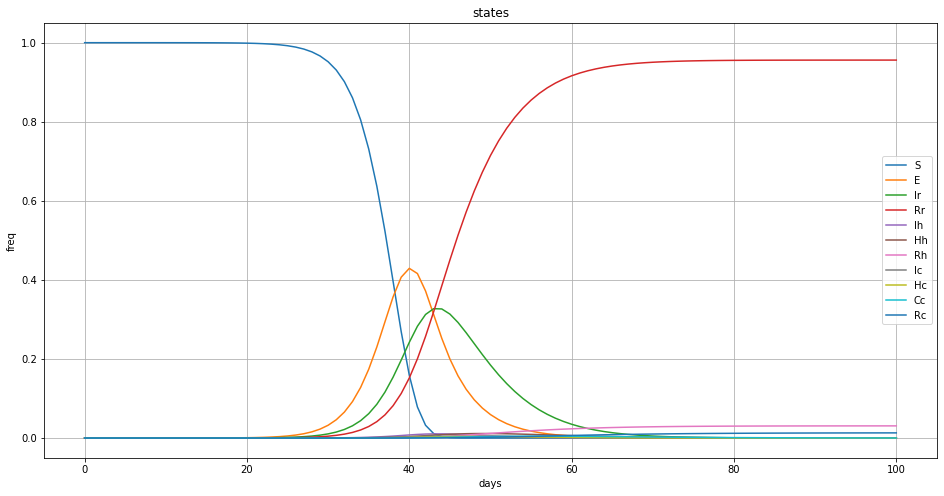

In [22]:
# visualize each state's relative frequency over time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
fig.set_size_inches(16, 8)

# don't do this
t = [i for i in range(len(results["E"]))]

# ax.plot(t, results["E"])
for state in states:
    ax.plot(t, results[state], label=state)

ax.set(xlabel="days", ylabel="freq", title="states")
ax.legend()
ax.grid()

plt.show()